# CLIP with conformal prediction

Comparing prediciton set size across different datasets

In [13]:
from pathlib import Path
from functools import partial
import pandas as pd
import matplotlib.pyplot as plt; plt.style.use('bmh')
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
assert torch.cuda.is_available()
import open_clip
from tqdm import tqdm
from dataset import DS, DatasetC
from conformal import get_pset_size, plot_violin
from zsclip import zero_shot_clip
# import wilds

## CLIP model

In [14]:
tokenizer = open_clip.get_tokenizer('ViT-B-32-quickgelu')
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32-quickgelu', pretrained='laion400m_e32')

## Datasets

In [15]:
data_dir = Path('../data')
# cifar_train = datasets.CIFAR100(root=data_dir, download = True, train=True)
cifar_test = datasets.CIFAR100(root=data_dir, download = True, train=False)

Files already downloaded and verified


In [16]:
cifar_classes = tuple(cifar_test.classes)
cifar_class_map = dict(map(reversed, cifar_test.class_to_idx.items()))

In [17]:
cifar_test_dataset = DS(
    cifar_test.data, cifar_test.targets,
    transforms=transforms.Compose([
        # transforms.ToTensor(),
        # transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762)),
        transforms.ToPILImage(),
        preprocess
    ]), 
)
# loader_params = dict(batch_size=16, shuffle=False, pin_memory=True, num_workers=8)
# cifar_test_loader = DataLoader(cifar_test_dataset, **loader_params)

## Random char swap prompts

In [7]:
import random
def random_swap(string):
    """Randomly swaps two characters in a string."""
    if len(string) < 2:
        raise ValueError("String must have at least 2 characters")
    string_list = list(string)
    index1 = random.randint(0, len(string) - 1)
    index2 = random.randint(0, len(string) - 1)
    while index1 == index2:
        index2 = random.randint(0, len(string) - 1)
    string_list[index1], string_list[index2] = string_list[index2], string_list[index1]
    return ''.join(string_list)

In [8]:
random_swap('a photo of a dog')

'agphoto of a do '

In [9]:
images = [cifar_test_dataset[i][0] for i in range(len(cifar_test_dataset))]
images = torch.stack(images)
labels = [cifar_test_dataset[i][1] for i in range(len(cifar_test_dataset))]
prompts = ['This is an image of a ' + c for c in cifar_classes]
prompts = [random_swap(p) for p in prompts]

In [15]:
random_swap('This is an image of a dog')

'This is an  mageiof a dog'

Conformal analysis for CIFAR100 dataset
Accuracy: 36.4%
Coverage: 90.3%
Set size: 34.4


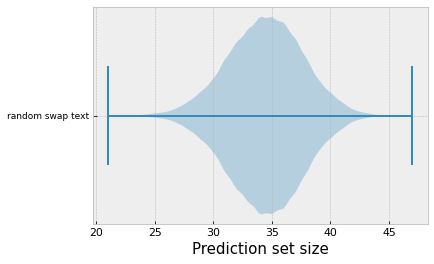

In [10]:
print('Conformal analysis for CIFAR100 dataset')

accs = []
psets_sizes = []
str_labels = []        
cifar_true_class, cifar_pred_scores, cifar_acc = zero_shot_clip(model, tokenizer, images, labels, prompts)
cifar_psets_size = get_pset_size(cifar_true_class, cifar_pred_scores)
accs.append(cifar_acc)
psets_sizes.append(cifar_psets_size)
str_labels.append('random swap text')
        
plot_violen(num=1, psets_sizes=psets_sizes, str_labels=str_labels, figname='pset_swap1.png')


## Random char swap classes

In [ ]:
images = [cifar_test_dataset[i][0] for i in range(len(cifar_test_dataset))]
images = torch.stack(images)
labels = [cifar_test_dataset[i][1] for i in range(len(cifar_test_dataset))]
cifar_classes_swap = [random_swap(c) for c in cifar_classes]
prompts = ['This is an image of a ' + c for c in cifar_classes_swap]

In [18]:
prompts[0]

'This is an image of a ppale'

Conformal analysis for CIFAR100 dataset
Accuracy: 10.7%
Coverage: 89.7%
Set size: 75.0


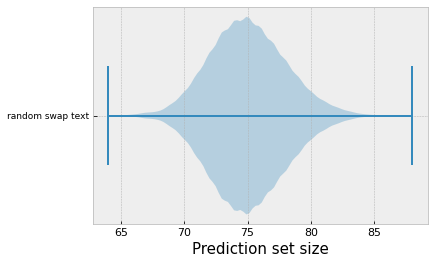

In [19]:
print('Conformal analysis for CIFAR100 dataset')

accs = []
psets_sizes = []
str_labels = []        
cifar_true_class, cifar_pred_scores, cifar_acc = zero_shot_clip(model, tokenizer, images, labels, prompts)
cifar_psets_size = get_pset_size(cifar_true_class, cifar_pred_scores)
accs.append(cifar_acc)
psets_sizes.append(cifar_psets_size)
str_labels.append('random swap text')
        
plot_violen(num=1, psets_sizes=psets_sizes, str_labels=str_labels, figname='pset_swap2.png')


## Perturbation with Stable Diffusion

In [18]:
from stablediffusion import stablediffusion

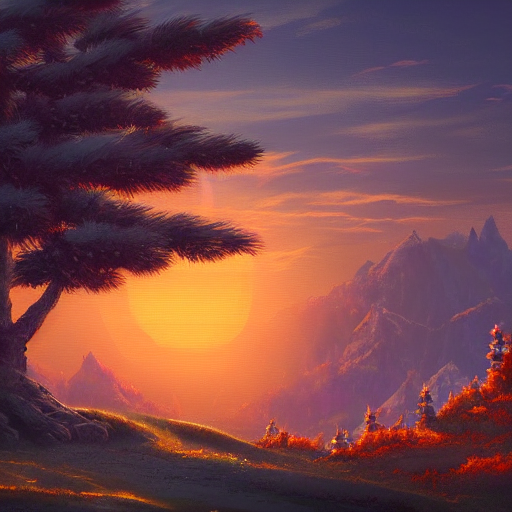

In [9]:
prompt = "A fantasy landscape with a pine tree in the foreground and a red sun setting in the distance, trending on artstation"
seed = 2483964025
stablediffusion(prompt, seed=seed)

In [19]:
cifar_test_dataset = DS(
    cifar_test.data, cifar_test.targets,
    transforms=transforms.Compose([
        # transforms.ToTensor(),
        # transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762)),
        transforms.ToPILImage(),
    ]), 
)

### watercolor painting

In [79]:
# import pyyaml module
import yaml
from yaml.loader import SafeLoader

with open('cifar100_superclasses.yaml') as f:
    cifar100_superclasses = yaml.load(f, Loader=SafeLoader)

In [82]:
prompts = ['This is an image of a ' + c for c in cifar_classes]

### experiments

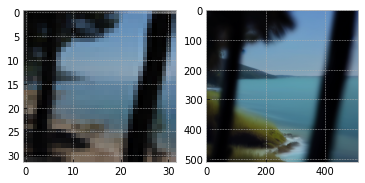

In [38]:
x, y = cifar_test_dataset[10]
x_new = stablediffusion(
        'This is an image of a ' + cifar_classes[y],  
        'This is a watercolor painting of a ' + cifar_classes[y], 
        seed=115, 
        init_image=x,
        init_image_strength=0.7
      )
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(x)
ax2.imshow(x_new)

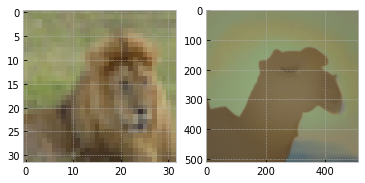

In [33]:
x, y = cifar_test_dataset[15]
x_new = stablediffusion(
        'This is an image of a ' + cifar_classes[15],  
        'This is a watercolor painting of a ' + cifar_classes[15], 
        seed=115, 
        init_image=x,
        init_image_strength=0.7
      )
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(x)
ax2.imshow(x_new)

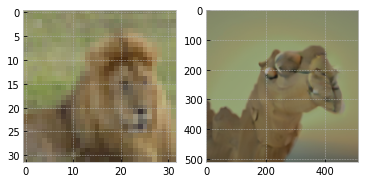

In [41]:
x, y = cifar_test_dataset[15]
x_new = stablediffusion(
        'This is an image of a ' + cifar_classes[15],  
        'This is an image of a ' + cifar_classes[15], 
        seed=115, 
        init_image=x,
        init_image_strength=0.7
      )
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(x)
ax2.imshow(x_new)

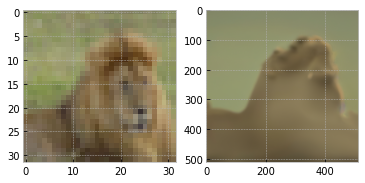

In [61]:
x, y = cifar_test_dataset[15]
x_new = stablediffusion( 
        prompt_edit = 'This is an image of a ' + cifar_classes[15], 
        seed=115, 
        init_image=x,
        init_image_strength=0.65
      )
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(x)
ax2.imshow(x_new)

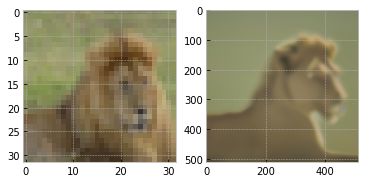

In [83]:
x, y = cifar_test_dataset[15]
x_new = stablediffusion(
        'This is an image of a ' + cifar_classes[y],  
        'This is an image of a ' + cifar_classes[15], 
        seed=115, 
        init_image=x,
        init_image_strength=0.7
      )
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(x)
ax2.imshow(x_new)

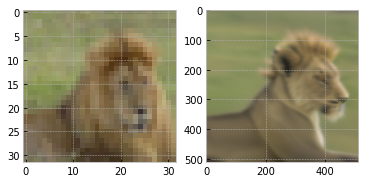

In [84]:
x, y = cifar_test_dataset[15]
x_new = stablediffusion(
        'This is an image of a ' + cifar_classes[y],  
        'This is an image of a ' + 'leopard', 
        seed=115, 
        init_image=x,
        init_image_strength=0.7
      )
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(x)
ax2.imshow(x_new)

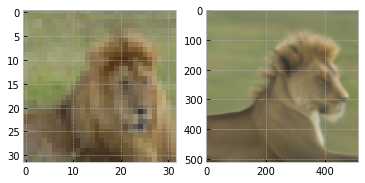

In [85]:
x, y = cifar_test_dataset[15]
prompt = 'This is an image of a ' + cifar_classes[y]
x_new = stablediffusion(
        prompt,  
        prompt.replace(cifar_classes[y], superclasses[cifar_classes[y]]), 
        seed=115, 
        init_image=x,
        init_image_strength=0.7
      )
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(x)
ax2.imshow(x_new)

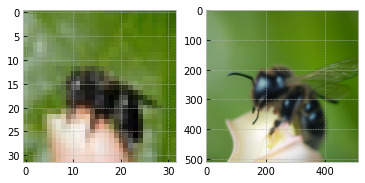

In [87]:
x, y = cifar_test_dataset[83]
prompt = 'This is an image of a ' + cifar_classes[y]
x_new = stablediffusion(
        prompt,  
        prompt.replace(cifar_classes[y], superclasses[cifar_classes[y]]), 
        seed=115, 
        init_image=x,
        init_image_strength=0.7
      )
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(x)
ax2.imshow(x_new)

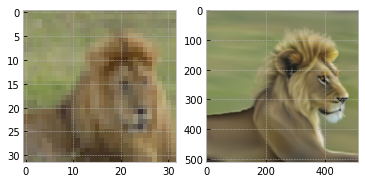

In [37]:
x, y = cifar_test_dataset[15]
x_new = stablediffusion(
        'This is an image of a ' + cifar_classes[y],  
        'This is a watercolor painting of a ' + cifar_classes[y], 
        seed=115, 
        init_image=x,
        init_image_strength=0.7
      )
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(x)
ax2.imshow(x_new)

### code

In [21]:
images = []
labels = []
for i in tqdm(range(len(cifar_test_dataset))):
    x, y = cifar_test_dataset[i]
    x_new = stablediffusion(
        'This is an image of a ' + cifar_classes[y],  
        'This is a watercolor painting of a ' + cifar_classes[y], 
        seed=115, 
        init_image=x,
        init_image_strength=0.7
      )
    images.append(preprocess(x_new))
    labels.append(y)
images = torch.stack(images)  

In [ ]:
prompts = ['This is an image of a ' + c for c in cifar_classes]
prompts_new = ['This is a watercolor painting of a ' + c for c in cifar_classes]

In [ ]:
print('Conformal analysis for CIFAR100 dataset')

accs = []
psets_sizes = []
str_labels = []        

cifar_true_class, cifar_pred_scores, cifar_acc = zero_shot_clip(model, tokenizer, images, labels, prompts)
cifar_psets_size = get_pset_size(cifar_true_class, cifar_pred_scores)
accs.append(cifar_acc)
psets_sizes.append(cifar_psets_size)
str_labels.append('original prompts')

cifar_true_class, cifar_pred_scores, cifar_acc = zero_shot_clip(model, tokenizer, images, labels, prompts_new)
cifar_psets_size = get_pset_size(cifar_true_class, cifar_pred_scores)
accs.append(cifar_acc)
psets_sizes.append(cifar_psets_size)
str_labels.append('new prompts')
        
plot_violen(num=12, psets_sizes=psets_sizes, str_labels=str_labels, figname='pset_watercolor_painting.png')
